<table class="ee-notebook-buttons" align="left">
    <td><a target="_parent"  href="https://github.com/MVOSlab-sdstate/AST426_Lab/blob/main/AST%20426L%20Lab%2009/AST426L%20Lab9.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td>
    <td><a target="_parent"  href="https://nbviewer.org/github/MVOSlab-sdstate/AST426_Lab/blob/main/AST%20426L%20Lab%2009/AST426L%20Lab9.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
    <td><a target="_parent"  href="https://colab.research.google.com/github/MVOSlab-sdstate/AST426_Lab/blob/main/AST%20426L%20Lab%2009/AST426L%20Lab9.ipynb"><img width=26px src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
    </table>

<p style = "font-size: large; font-family:'Georgia';"> Install necessary packages if not installed </p>

In [ ]:
# Install necessary packages if not installed
!pip install geemap pandas

<p style = "font-size: large; font-family:'Georgia';"> Import libraries </p>

In [ ]:
# Import libraries
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ee
import geemap
import pandas as pd
import requests
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

In [ ]:
# Authenticate and initialize Google Earth Engine API
ee.Authenticate()

# Change 'my-project' to your actual project
ee.Initialize(project='ee-mvoslabsdstate')

<p style = "font-size: X-large; font-family:'Georgia';"> Load Brookings County Boundary and Visualize it on a Map </p>

In [ ]:
# Load the boundary for Brookings County, SD
counties = ee.FeatureCollection("TIGER/2018/Counties")
brookings_county = counties.filter(ee.Filter.eq('NAME', 'Brookings')).filter(ee.Filter.eq('STATEFP', '46'))

# Create a map to visualize Brookings County
Map = geemap.Map(center=[44.3, -96.8], zoom=10)  # Centered around Brookings County

# Add Brookings County boundary to the map with blue color
Map.addLayer(brookings_county.style(**{'color': 'blue', 'fillColor': '00000000', 'width': 3}), {}, 'Brookings County')

# Display the map
Map


Map(center=[44.3, -96.8], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

<p style = "font-size: X-large; font-family:'Georgia';"> Load Sentinel-2 Data and Define NDVI Calculation </p>

In [ ]:
# Load the Sentinel-2 Harmonized Surface Reflectance (S2_SR_HARMONIZED) image collection
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(brookings_county) \
    .filterDate('2015-05-01', '2024-09-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Only consider images with less than 10% cloud cover

# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # B8 is NIR, B4 is Red for Sentinel-2
    return image.addBands(ndvi)

# Apply the NDVI calculation function to the Sentinel-2 image collection
sentinel_ndvi = sentinel2.map(calculate_ndvi).select('NDVI')


<p style = "font-size: X-large; font-family:'Georgia';"> Calculate Mean NDVI for Each Year in Brookings County.This step will take sometime. Please have some patience. </p>

In [ ]:
# Function to calculate the mean NDVI for Brookings County
def get_ndvi_mean(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')

    # Calculate the mean NDVI for Brookings County
    ndvi_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=brookings_county.geometry(),
        scale=10,  # Sentinel resolution is 10 meters
        maxPixels=1e8,  # Set a high maxPixels value
        bestEffort=True  # Allow Earth Engine to adjust scale if too many pixels
    ).get('NDVI')

    return image.set('date', date).set('NDVI', ndvi_value)

# Extract NDVI data for Brookings County from 2015 to 2024
results = []
for year in range(2015, 2024):
    start_date = f'{year}-05-01'
    end_date = f'{year}-09-30'

    # Filter the Sentinel-2 image collection by the date range and apply the NDVI mean function
    collection = sentinel_ndvi.filterDate(start_date, end_date).map(get_ndvi_mean)

    # Extract NDVI values and dates
    ndvi_values = collection.aggregate_array('NDVI').getInfo()
    dates = collection.aggregate_array('date').getInfo()

    # Filter out None values and ensure lengths match
    valid_entries = [(date, ndvi) for date, ndvi in zip(dates, ndvi_values) if ndvi is not None]

    if valid_entries:
        dates, ndvi_values = zip(*valid_entries)
        ndvi_df = pd.DataFrame({'Date': dates, 'NDVI': ndvi_values})

        # Calculate the average NDVI for the growing season
        avg_ndvi = ndvi_df['NDVI'].mean()
    else:
        avg_ndvi = None  # Handle cases where no valid data is available

    # Store the year and average NDVI value
    results.append([year, avg_ndvi])

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Year', 'Avg_NDVI'])

# Display the NDVI data
results_df


,Year,Avg_NDVI
0,2015,NaN
1,2016,NaN
2,2017,NaN
3,2018,NaN
4,2019,0.596180
5,2020,0.567753
6,2021,0.574377
7,2022,0.593178
8,2023,0.533034


<p style = "font-size: X-large; font-family:'Georgia';"> Fetch Corn Yield Data for Brookings County. You will need your API Key from USDA NASS. If your field based on your lab group didn't have corn for the year 2023, then you will need to make changes accordingly, to fetch the right crop's yield values.
</p>

In [ ]:
# Fetch USDA NASS Quick Stats API key
api_key = 'E792A653-CE5E-3AAC-84A4-AA0F849EFD54'

# Function to fetch corn yield data for Brookings County from the USDA NASS API
def get_yield_data(year):
    base_url = "https://quickstats.nass.usda.gov/api/api_GET/"
    params = {
        'key': api_key,
        'commodity_desc': 'CORN',
        'year__GE': year,
        'year__LE': year,
        'agg_level_desc': 'COUNTY',
        'state_name': 'SOUTH DAKOTA',
        'county_name': 'BROOKINGS',
        'short_desc': 'CORN, GRAIN - YIELD, MEASURED IN BU / ACRE',
        'format': 'JSON'
    }
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()
        if len(data['data']) > 0:
            # Average the values if multiple records are returned
            yield_values = [float(record['Value'].replace(",", "")) for record in data['data']]
            return sum(yield_values) / len(yield_values) if yield_values else None
        else:
            return None
    else:
        print(f"Error fetching data for year {year}: {response.status_code}")
        return None

# Fetch yield data for each year and add to the results DataFrame
results_df['Yield (bu/acre)'] = results_df['Year'].apply(get_yield_data)

# Display the combined NDVI and Yield data
results_df


,Year,Avg_NDVI,Yield (bu/acre)
0,2015,NaN,184.837500
1,2016,NaN,184.914286
2,2017,NaN,180.000000
3,2018,NaN,178.360000
4,2019,0.596180,173.225000
5,2020,0.567753,173.225000
6,2021,0.574377,167.433333
7,2022,0.593178,169.800000
8,2023,0.533034,164.700000


<p style = "font-size: X-large; font-family:'Georgia';"> Save the Data to a CSV File. The CSV file will automatically download as well. Make sure to upload it on D2L along with your homework2 submission.After this code cell runs successfully, right-click on the left side anywhere below list of files and directories and refresh to see the csv fiel also being present on Colab.
</p>

In [ ]:
# Save the data to a CSV file
results_df.to_csv('ndvi_yield_brookings_2015_2024.csv', index=False)

# Download the CSV file
files.download('ndvi_yield_brookings_2015_2024.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<p style = "font-size: X-large; font-family:'Georgia';"> Linear Regression Analysis. Make sure Add your name and student ID in the plot title. </p>

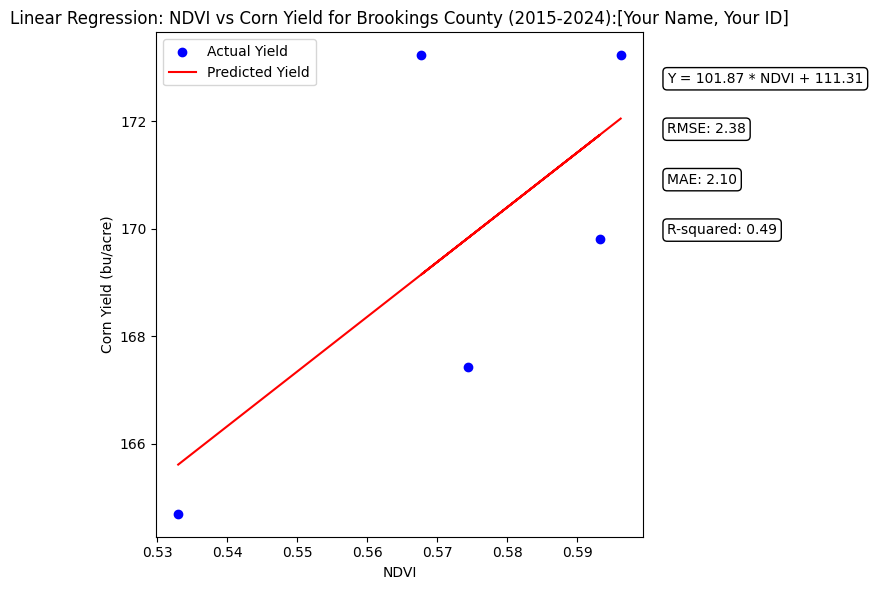

In [ ]:
# Prepare the data for linear regression (ignoring missing values)
filtered_data = results_df.dropna()
X = filtered_data[['Avg_NDVI']].values  # NDVI values
y = filtered_data['Yield (bu/acre)'].values  # Yield values

# Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r_squared = r2_score(y, y_pred)

# Plot the results
plt.figure(figsize=(8,6))
plt.scatter(X, y, color='blue', label='Actual Yield')
plt.plot(X, y_pred, color='red', label='Predicted Yield')

# Get the current axis to modify the layout
ax = plt.gca()

# Display equation, RMSE, MAE, and R-squared just outside the right side of the plot
equation = f'Y = {model.coef_[0]:.2f} * NDVI + {model.intercept_:.2f}'
rmse_text = f'RMSE: {rmse:.2f}'
mae_text = f'MAE: {mae:.2f}'
r2_text = f'R-squared: {r_squared:.2f}'

# Use ax.annotate() to position the text outside the plot area on the right
props = dict(boxstyle='round', facecolor='white', edgecolor='black')

# Annotate the text outside the right edge
ax.annotate(equation, xy=(1.05, 0.9), xycoords='axes fraction', fontsize=10, color='black', bbox=props)
ax.annotate(rmse_text, xy=(1.05, 0.8), xycoords='axes fraction', fontsize=10, color='black', bbox=props)
ax.annotate(mae_text, xy=(1.05, 0.7), xycoords='axes fraction', fontsize=10, color='black', bbox=props)
ax.annotate(r2_text, xy=(1.05, 0.6), xycoords='axes fraction', fontsize=10, color='black', bbox=props)

# Add labels and title
plt.xlabel('NDVI')
plt.ylabel('Corn Yield (bu/acre)')
plt.title('Linear Regression: NDVI vs Corn Yield for Brookings County (2015-2024):[Your Name, Your ID]')
plt.legend()

# Adjust the layout so that everything fits
plt.tight_layout()

# Show the plot
plt.show()



<p style = "font-size: X-large; font-family:'Georgia';"> Predict Corn Yield for a Specific Farm using GPS Coordinates. Make sure to provide GPS coordinates of the farm allocated to you based on your Lab Group. </p>

In [ ]:
# Function to define farm AOI based on top-left and bottom-right GPS coordinates
def define_farm_aoi(top_left, bottom_right):
    return ee.Geometry.Rectangle([top_left[1], bottom_right[0], bottom_right[1], top_left[0]])

# Function to calculate the center of the farm AOI
def calculate_center(top_left, bottom_right):
    center_lat = (top_left[0] + bottom_right[0]) / 2  # Average of latitudes
    center_lon = (top_left[1] + bottom_right[1]) / 2  # Average of longitudes
    return center_lat, center_lon

# Example GPS coordinates (replace with actual coordinates)
top_left = [44.325488, -96.667085]  # Replace with top-left GPS coordinates (Latitude, Longitude)
bottom_right = [44.318469, -96.662271]  # Replace with bottom-right GPS coordinates (Latitude, Longitude)

# Define the farm AOI
farm_aoi = define_farm_aoi(top_left, bottom_right)

# Calculate the center of the farm AOI
center_lat, center_lon = calculate_center(top_left, bottom_right)

# Create a map to visualize the farm AOI
Map_farm = geemap.Map(center=[center_lat, center_lon], zoom=14)  # Dynamically centered around the farm
Map_farm.addLayer(farm_aoi, {'color': 'blue','fillColor': '00000000', 'width': 3}, 'Farm AOI')

# Display the map
Map_farm


Map(center=[44.3219785, -96.66467800000001], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

<p style = "font-size: X-large; font-family:'Georgia';"> Calculate NDVI for the Farm AOI. After this code cell runs successfully, before moving any furthur, verify the crop type in your farm for the year 2023. </p>
<p style = "font-size: X-large; font-family:'Georgia';">If it's other than corn, then you will have to jump back to the 7th code cell where you fetch yield data using the USDA NASS API. Then based upon your crop type for the year 2023 (use lab#5 for reference), repeat all the steps from there. </p>

In [ ]:
# Function to calculate the mean NDVI for the farm AOI
def get_ndvi_mean_farm(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')

    # Calculate the mean NDVI for the farm AOI
    ndvi_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=farm_aoi,
        scale=10,  # Sentinel resolution is 10 meters
        maxPixels=1e8,  # Set a high maxPixels value
        bestEffort=True  # Allow Earth Engine to adjust scale if too many pixels
    ).get('NDVI')

    return image.set('date', date).set('NDVI', ndvi_value)

# Calculate NDVI for the farm AOI for the year 2023 (for example)
farm_results = []
start_date = '2023-05-01'
end_date = '2023-09-30'

# Filter the Sentinel-2 image collection by the date range and apply the NDVI mean function
farm_collection = sentinel_ndvi.filterDate(start_date, end_date).map(get_ndvi_mean_farm)

# Extract NDVI values and dates
farm_ndvi_values = farm_collection.aggregate_array('NDVI').getInfo()
farm_dates = farm_collection.aggregate_array('date').getInfo()

# Filter out None values and ensure lengths match
valid_farm_entries = [(date, ndvi) for date, ndvi in zip(farm_dates, farm_ndvi_values) if ndvi is not None]

if valid_farm_entries:
    farm_dates, farm_ndvi_values = zip(*valid_farm_entries)
    farm_ndvi_df = pd.DataFrame({'Date': farm_dates, 'NDVI': farm_ndvi_values})

    # Calculate the average NDVI for the farm during the growing season
    avg_farm_ndvi = farm_ndvi_df['NDVI'].mean()
else:
    avg_farm_ndvi = None  # Handle cases where no valid data is available

# Display the average NDVI for the farm
print(f'Average NDVI for the farm in 2023: {avg_farm_ndvi}')


Average NDVI for the farm in 2023: 0.6645441812551439


<p style = "font-size: X-large; font-family:'Georgia';"> Predict Corn Yield for the Farm Using the Linear Regression Model. After this code cell runs successfully, make sure to provide shareable link in your homework submission draft. Do not foget to remove the restriction while getting your sharable link. Provide the bushel/acre value in your homework draft. </p>

In [ ]:
# Check if NDVI data is available for the farm
if avg_farm_ndvi is not None:
    # Reshape the data for prediction
    farm_ndvi_input = np.array([[avg_farm_ndvi]])

    # Predict the corn yield using the trained linear regression model
    predicted_yield = model.predict(farm_ndvi_input)

    # Display the predicted corn yield for the farm
    print(f'Predicted corn yield for the farm in 2023: {predicted_yield[0]:.2f} bu/acre')
else:
    print("No valid NDVI data available for the farm in 2023.")


Predicted corn yield for the farm in 2023: 179.01 bu/acre
